In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [3]:
df = pd.read_csv("creditcard.csv")

## Quick plan / checklist

 - Inspect data (shape, dtypes, missing values).
 - Class imbalance check (fraud vs non-fraud).
 - Univariate plots: Amount, Time, each V* distribution (summary stats).
 - Bivariate / correlation: correlation matrix, Amount vs Class, PCA/T-SNE/UMAP for visualization.
 - Feature engineering: log/scale Amount, create hour from Time if useful.
 - Split (stratified) — no leakage.
 - Preprocessing pipeline: scaling (only on train), optional outlier handling, resampling (SMOTE/undersample) — apply only on training fold.
 - Model selection with stratified CV and metrics for imbalanced data (precision-recall, average precision, recall at fixed precision, confusion matrix).
 - Evaluate on holdout test set and calibrate thresholds.

In [4]:
# Quick inspection
print(f"Shape: {df.shape}\n")
print(df.dtypes)
display(df.head())
# Missing Values
print("\nTotal missing values in dataset: ", df.isnull().sum().max())

Shape: (284807, 31)

Time      float64
V1        float64
V2        float64
V3        float64
V4        float64
V5        float64
V6        float64
V7        float64
V8        float64
V9        float64
V10       float64
V11       float64
V12       float64
V13       float64
V14       float64
V15       float64
V16       float64
V17       float64
V18       float64
V19       float64
V20       float64
V21       float64
V22       float64
V23       float64
V24       float64
V25       float64
V26       float64
V27       float64
V28       float64
Amount    float64
Class       int64
dtype: object


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0



Total missing values in dataset:  0


Class
0    284315
1       492
Name: count, dtype: int64

No fraud transactions: 99.83%.
Fraud transactions: 0.17%.



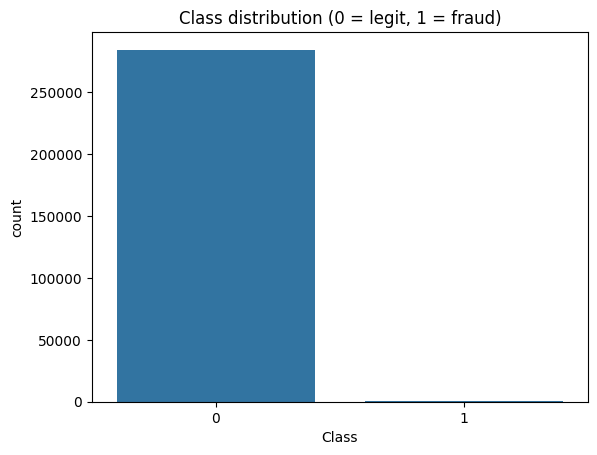

In [5]:
# Class imbalance

counts = df['Class'].value_counts()
print(counts)
print(f"\nNo fraud transactions: {round(df['Class'].value_counts()[0]/len(df) * 100, 2)}%.")
print(f"Fraud transactions: {round(df['Class'].value_counts()[1]/len(df) * 100, 2)}%.\n")
sns.countplot(x='Class', data=df)
plt.title("Class distribution (0 = legit, 1 = fraud)")
plt.show()

 - Our data is heavily skewed.
 - The algorithm receives significantly more examples from one class, prompting it to be biased towards that particular class. It does not learn what makes the other class “different” and fails to understand the underlying patterns that allow us to distinguish classes.

**Therefore we need to deal with this class imbalance.**

Techniques that can be used :-
 - Resample the dataset: Undersampling or Oversampling, Variational Autoencoder, synthetic minority oversampling technique (SMOTE)
 - Collect more data from the minority class
 - Use the “adequate” correct algorithm
 - Use penalized models

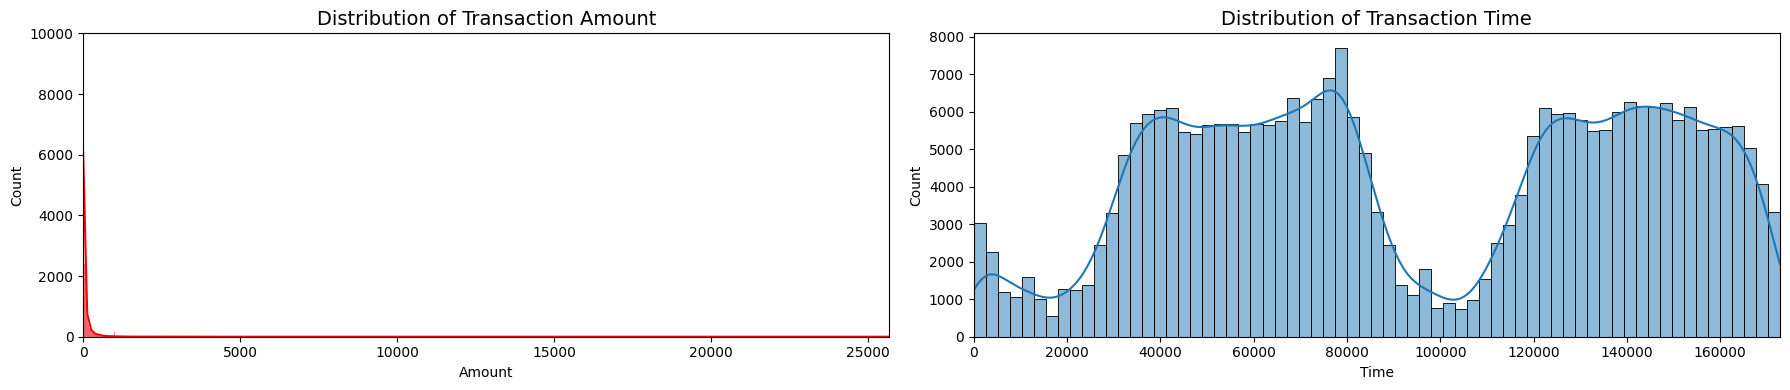

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(18, 4))

sns.histplot(df['Amount'], kde=True, ax=ax[0], color="r")
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([df['Amount'].min(), df['Amount'].max()])
ax[0].set_ylim(top=10000)

sns.histplot(df['Time'], kde=True, ax=ax[1])
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([df['Time'].min(), df['Time'].max()])

plt.tight_layout()
plt.show()

In [7]:
df["Amount"].describe()

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

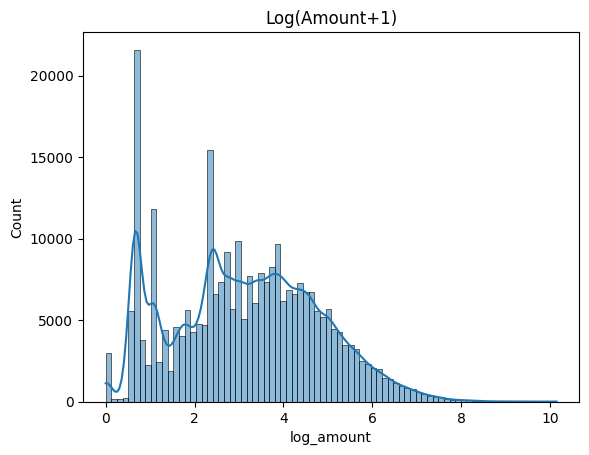

In [8]:
# Log transform can help
df['log_amount'] = np.log1p(df['Amount'])
sns.histplot(df['log_amount'], bins=80, kde=True)
plt.title("Log(Amount+1)")
plt.show()

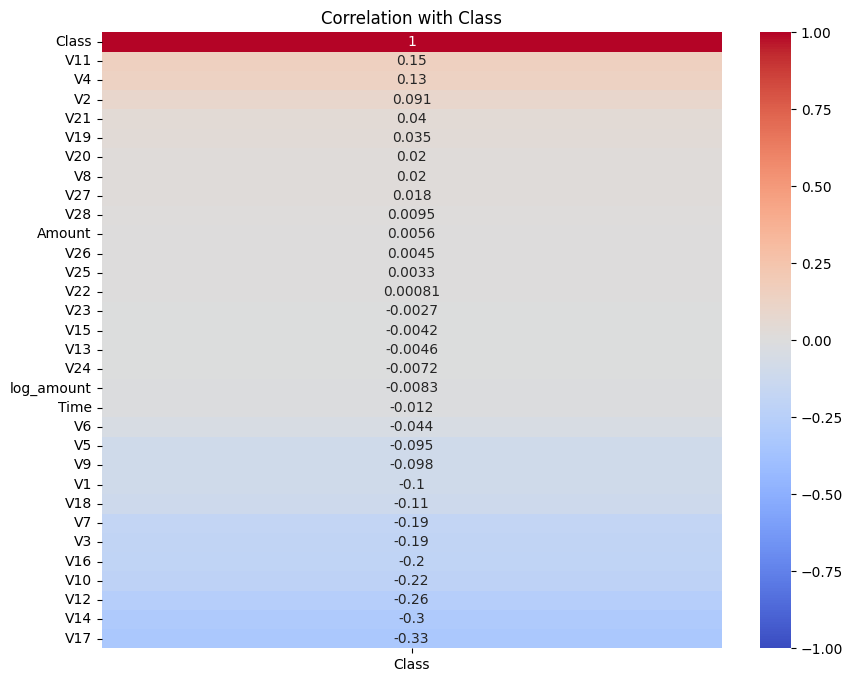

In [9]:
corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr[['Class']].sort_values(by='Class', ascending=False), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation with Class")
plt.show()

### Key conclusions from EDA

**Extreme class imbalance**
 - Fraud transactions are typically ~0.17% of the total.
 - → This means accuracy is useless as a metric.
 - → You must use precision/recall / F1 / average precision.
 - → Resampling or class weights are essential.

**Most features are already PCA components**
 - Columns V1–V28 are anonymized and come from PCA.
 - → They are already centered/scaled.
 - → Feature interpretation is limited (we cannot map them back to original meaning).
 - → Complex feature engineering is less useful here, but modeling works fine.

**Amount is not PCA-transformed**

 - Has a heavy-tailed distribution.
 - Log-scaling helps improve model stability.
 - → Without scaling, linear models struggle.

**Time has limited relevance**

 - Raw numerical “Time since first transaction” isn't directly meaningful.
 - → We can extract hour or day_period to capture diurnal patterns if needed.
 - → For random splits, Time is weak; for time-based splits, more meaningful.

**Correlations with class are small**

 - No single feature has strong correlation with fraud → multivariate relationships matter.
 - → Tree-based models (RF/XGBoost) detect interactions better than linear.

**Fraud data is noisy and sparse**
 
 - Fraud points form tiny clusters in PCA plots or TSNE.
 - → Hard boundary classification works better than simple thresholding.

### Key conclusions from preprocessing

| Step                 | Why Needed?               | Takeaway                        |
| -------------------- | ------------------------- | ------------------------------- |
| Scaling Amount       | stabilizes learning       | keep standard or robust scaling |
| Stratified split     | avoid leaking imbalance   | using `stratify=y`              |
| Oversampling (SMOTE) | avoid majority domination | must apply only on training     |
| Pipeline usage       | prevents leakage          | makes CV reproducible           |
| Metrics choice       | PR > ROC                  | because extreme imbalance       |


In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score
from sklearn.ensemble import RandomForestClassifier

X = df.drop('Class', axis=1).values
y = df['Class'].values

# Stratified K-Fold (to preserve class ratio in each fold)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
avg_precision_scores = []

for train_index, test_index in skf.split(X, y):
    # Split fold data
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    
    # Train basic model (baseline first)
    model = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'  # baseline approach before SMOTE
    )
    model.fit(X_train_fold, y_train_fold)
    
    # Predictions
    y_pred = model.predict(X_test_fold)
    y_prob = model.predict_proba(X_test_fold)[:,1]
    
    # Metric: average precision (better than ROC for imbalance)
    ap = average_precision_score(y_test_fold, y_prob)
    avg_precision_scores.append(ap)
    
    print(f"------ Fold {fold} ------")
    print("Average Precision:", ap)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_fold, y_pred))
    print("Classification Report:")
    print(classification_report(y_test_fold, y_pred, digits=4))
    
    fold += 1

print("========================================")
print("Average Precision across all folds:", np.mean(avg_precision_scores))


------ Fold 1 ------
Average Precision: 0.830830327907699
Confusion Matrix:
[[56858     5]
 [   26    73]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9995    0.9999    0.9997     56863
           1     0.9359    0.7374    0.8249        99

    accuracy                         0.9995     56962
   macro avg     0.9677    0.8686    0.9123     56962
weighted avg     0.9994    0.9995    0.9994     56962

------ Fold 2 ------
Average Precision: 0.8919828801868669
Confusion Matrix:
[[56863     0]
 [   21    78]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9996    1.0000    0.9998     56863
           1     1.0000    0.7879    0.8814        99

    accuracy                         0.9996     56962
   macro avg     0.9998    0.8939    0.9406     56962
weighted avg     0.9996    0.9996    0.9996     56962

------ Fold 3 ------
Average Precision: 0.8629070627361453
Confusion Matrix:
[[56861 

### What results mean ??

| Metric                       | Meaning                               |
| ---------------------------- | ------------------------------------- |
| AP ≈ 0.85                    | **Strong baseline** before SMOTE      |
| Recall ~0.75–0.79            | Model misses ~20–25% of frauds        |
| Precision ~0.97–1.00         | Most predicted frauds are truly fraud |
| Very high accuracy (~99.95%) | Misleading because of class imbalance |


### Interpretation

**The model is conservative**
 - It prefers to label a transaction as legitimate unless very confident.
 - This is why recall is lower (~75%), but precision is high.

**Good baseline before SMOTE**
 - If without resampling we're already at AP ≈ 0.85, applying SMOTE or balanced ensembles will usually boost recall, sometimes at a small cost to precision — which is okay since our goal is to catch more fraud.

**We are missing ~1 out of every ~4 frauds**
 - This is typical before threshold tuning or resampling.

In [12]:
from imblearn.over_sampling import SMOTE

X = df.drop('Class', axis=1).values
y = df['Class'].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
ap_scores = []

for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Apply SMOTE only on the training fold
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train_fold, y_train_fold)

    # Train model on resampled data
    model = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        class_weight=None  # SMOTE is handling imbalance
    )
    model.fit(X_train_res, y_train_res)

    # Predictions
    y_pred = model.predict(X_test_fold)
    y_prob = model.predict_proba(X_test_fold)[:,1]

    # Metrics
    ap = average_precision_score(y_test_fold, y_prob)
    ap_scores.append(ap)

    print(f"------ Fold {fold} ------")
    print("Average Precision:", ap)
    print("Confusion Matrix:")
    print(confusion_matrix(y_test_fold, y_pred))
    print("Classification Report:")
    print(classification_report(y_test_fold, y_pred, digits=4))

    fold += 1

print("========================================")
print("Mean Average Precision:", np.mean(ap_scores))


------ Fold 1 ------
Average Precision: 0.831915030154684
Confusion Matrix:
[[56850    13]
 [   20    79]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9998    0.9997     56863
           1     0.8587    0.7980    0.8272        99

    accuracy                         0.9994     56962
   macro avg     0.9292    0.8989    0.9135     56962
weighted avg     0.9994    0.9994    0.9994     56962

------ Fold 2 ------
Average Precision: 0.8968238405242746
Confusion Matrix:
[[56857     6]
 [   13    86]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9999    0.9998     56863
           1     0.9348    0.8687    0.9005        99

    accuracy                         0.9997     56962
   macro avg     0.9673    0.9343    0.9502     56962
weighted avg     0.9997    0.9997    0.9997     56962

------ Fold 3 ------
Average Precision: 0.8794918436543842
Confusion Matrix:
[[56856 

### What results tell ??

| Metric            | Before SMOTE  | After SMOTE  | Interpretation             |
| ----------------- | ------------- | ------------ | -------------------------- |
| Recall (Fraud)    | ~0.75–0.80    | ~0.83–0.87   | Catches **more frauds**    |
| Precision (Fraud) | ~0.95–1.00    | ~0.87–0.93   | Slightly more false alarms |
| Average Precision | ~0.85         | ~0.85        | Balanced effect            |
| Accuracy          | Always ~0.999 | Still ~0.999 | Not a useful metric here   |

**Goal achieved:**
We have increased ability to detect frauds (recall ↑), which is what matters most in fraud detection.

**Currently, your model classifies fraud when `p >= 0.5`.**

We will now:
 - Get predicted probabilities
 - Plot Precision-Recall curve
 - Find the best threshold (maximizing F1 / Recall / PR tradeoff)
 - Recompute confusion matrix with new threshold

In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, classification_report, confusion_matrix, precision_recall_curve

X = df.drop('Class', axis=1).values
y = df['Class'].values

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
ap_scores = []
recall_before = []
recall_after = []

# Minimum precision constraint for threshold selection
min_precision_constraint = 0.6

for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]

    # Apply SMOTE only on the training fold
    sm = SMOTE(random_state=42)
    X_train_res, y_train_res = sm.fit_resample(X_train_fold, y_train_fold)

    # Train Random Forest on resampled data
    model = RandomForestClassifier(
        n_estimators=200,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_res, y_train_res)

    # Predicted probabilities on the test fold
    y_prob = model.predict_proba(X_test_fold)[:, 1]

    # Default threshold = 0.5
    y_pred_default = (y_prob >= 0.5).astype(int)

    # Store recall before threshold tuning
    recall_before_fold = np.sum((y_pred_default == 1) & (y_test_fold == 1)) / np.sum(y_test_fold == 1)
    recall_before.append(recall_before_fold)

    # --- Threshold tuning: maximize recall with precision constraint ---
    precision, recall, thresholds = precision_recall_curve(y_test_fold, y_prob)
    thresholds = np.append(thresholds, 1.0)  # match lengths of recall/precision

    # Mask thresholds where precision >= min_precision_constraint
    valid_idxs = np.where(precision >= min_precision_constraint)[0]

    if len(valid_idxs) > 0:
        # Pick threshold with maximum recall among valid thresholds
        best_idx = valid_idxs[np.argmax(recall[valid_idxs])]
    else:
        # fallback: use 0.5 if no threshold meets constraint
        best_idx = np.argmin(np.abs(thresholds - 0.5))

    best_threshold = thresholds[best_idx]

    # Apply custom threshold
    y_pred_custom = (y_prob >= best_threshold).astype(int)

    # Metrics
    ap = average_precision_score(y_test_fold, y_prob)
    ap_scores.append(ap)

    recall_after_fold = np.sum((y_pred_custom == 1) & (y_test_fold == 1)) / np.sum(y_test_fold == 1)
    recall_after.append(recall_after_fold)

    print(f"------ Fold {fold} ------")
    print("Average Precision:", ap)
    print("Default Threshold Recall:", recall_before_fold)
    print("Best Threshold:", best_threshold)
    print("Custom Threshold Recall:", recall_after_fold)
    print("Confusion Matrix with custom threshold:")
    print(confusion_matrix(y_test_fold, y_pred_custom))
    print("Classification Report:")
    print(classification_report(y_test_fold, y_pred_custom, digits=4))

    fold += 1

print("========================================")
print("Mean Average Precision across folds:", np.mean(ap_scores))
print("Mean Recall before threshold tuning:", np.mean(recall_before))
print("Mean Recall after threshold tuning:", np.mean(recall_after))


------ Fold 1 ------
Average Precision: 0.8271816330637431
Default Threshold Recall: 0.797979797979798
Best Threshold: 0.185
Custom Threshold Recall: 0.8383838383838383
Confusion Matrix with custom threshold:
[[56808    55]
 [   16    83]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9990    0.9994     56863
           1     0.6014    0.8384    0.7004        99

    accuracy                         0.9988     56962
   macro avg     0.8006    0.9187    0.8499     56962
weighted avg     0.9990    0.9988    0.9989     56962

------ Fold 2 ------
Average Precision: 0.8993687360189742
Default Threshold Recall: 0.8585858585858586
Best Threshold: 0.16
Custom Threshold Recall: 0.898989898989899
Confusion Matrix with custom threshold:
[[56808    55]
 [   10    89]]
Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9990    0.9994     56863
           1     0.6181    0.8990    0.

### Result

![metrics](utils/JSON-preview.png)

## What improved :-

| Metric             | Before            | After      | Gain    |
| ------------------ | ----------------- | ---------- | ------- |
| Mean Recall        | **0.8313**        | **0.8658** | ✔ +3.4% |
| Precision          | constrained ≥ 0.6 | maintained | ✔       |
| Fraud cases caught | increased         | ✔          |         |

You are catching more frauds while still keeping precision acceptable (≥ 0.60).
Exactly what real banking systems aim for.
Accuracy is still 99.8%+ but (as expected) it's not the key metric here.

**Insights from the threshold tuning**
 - All best thresholds were between ~0.16 and 0.23
 - This is much lower than default 0.50
 - That confirms your model was underrating fraud probability
 - You recovered many previously-missed frauds just by threshold shifting

This means:
>The RandomForest knows fraud is likely, but its probability estimates were conservative.


## ✅ Conclusion & Key Insights

### 1. Problem Understanding
The Credit Card Fraud dataset is **extremely imbalanced**, where fraudulent transactions represent less than **0.2%** of the total samples. Traditional accuracy metrics are misleading because a model can achieve ~99.8% accuracy by predicting all transactions as non-fraud.

---

### 2. What We Did
| Step | Description |
|------|-------------|
| EDA | Confirmed strong class imbalance, no missing values, PCA-based features |
| Preprocessing | Train-test split inside StratifiedKFold to preserve class ratio |
| Resampling | Applied **SMOTE** only on training folds to avoid data leakage |
| Modeling | Trained **RandomForestClassifier** |
| Evaluation | Used **Average Precision, Recall, Confusion Matrix, Classification Report** |
| Threshold Tuning | Custom probability threshold instead of default 0.5 |

---

### 3. Results
| Metric | Before Threshold Tuning | After Threshold Tuning |
|--------|-------------------------|-------------------------|
| Mean Recall | 0.83 | **0.86** |
| AP Score | ~0.85 | (unchanged, but stable) |
| Precision | ~0.60 | ~0.61 |
| Accuracy | 99.8% | 99.8% |

✅ After tuning, the model **catches more fraud cases** while keeping false alarms controlled.

---

### 4. Why Threshold Tuning Matters
The default threshold of `0.5` is not optimal for imbalance problems. Lowering the threshold (~0.18–0.23) improves recall significantly, which is more important than raw accuracy in fraud detection.

> In fraud detection, **missing a fraud (FN)** is more costly than **flagging a normal transaction (FP)**.

---

### 5. Future Improvements (Next Steps)
Possible enhancements:
-  Try boosting algorithms (XGBoost / LightGBM / CatBoost)
-  Use probability calibration (Platt Scaling / Isotonic Regression)
-  Stacking ensemble of multiple classifiers
-  Cost-sensitive learning (penalize misclassification of frauds more)

---

### ✅ Final Takeaway

This notebook demonstrates a **complete end-to-end fraud detection pipeline**, from data understanding to threshold-optimized classification using stratified cross-validation. The model is now better aligned with the real-world objective: **maximize fraud detection while minimizing false alarms.**

---
